
<font color=Grey size=6 face=微软雅黑>**租房价格分析原生爬虫**</font>

<font color=Orange size=5 face=微软雅黑>**取南开区与和平区的房源，定义一个类生成dataframe**</font>

<font color=b size=3 face=微软雅黑>**发送html请求，从网站上抓取想要的数据**</font>

In [1]:
from urllib import request
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


class Spider():     
    """用正则表达式定义抓取内容字符串"""
       
    root_pattern = '<div class="content__list--item--main">([\s\S]*?)</div>'
    way_pattern = 'html">([\s\S]*?)·'
    num_pattern = 'zufang/([\s\S]*?).html'
    name_pattern = '·([\s\S]*?) \d'
    price_pattern = '<em>([\s\S]*?)元/月'
    #district_pattern = '/heping/">([\s\S]*?)</a>'
    area_pattern = '<i>/</i>\s([\s\S]*?)"'
    
    
    def fetch_content(self):  #URL入口
        r = request.urlopen(web)
        htmls = r.read()
        htmls = str(htmls,encoding = 'utf-8')  #更改编码
        return htmls
    
    

    def analysis(self,htmls):  #将抓取内容转换为列表，列表中每一个元素为字典，目的为方便转换为dataframe
        root_html = re.findall(Spider.root_pattern,htmls)
        anchors=[]
        for html in root_html:
            
            num = re.findall(Spider.num_pattern,html)
            way = re.findall(Spider.way_pattern,html)
            name = re.findall(Spider.name_pattern,html)
            price = re.findall(Spider.price_pattern,html)
            #district = re.findall(Spider.district_pattern,html)
            area = re.findall(Spider.area_pattern,html)
            
            anchor = {'num':num,'way':way,'name':name,'price':price,'area':area}
            anchors.append(anchor)
      
        return anchors
    
    
  
    def refine(self,anchors): #内容精炼
        l = lambda x: { 
             'num':x['num'][0].strip(),
             'way':x['way'][0].strip(),
             'name':x['name'][0].strip()
             ,'price':x['price'][0].replace('</em>','')
            #,'district':x['district'][0].strip()
            ,'area':x['area'][0].strip().replace('<i>/</i>','').replace(' ','').replace('<spanclass=','')
         }
        return map(l,anchors)
    
      
    def go(self):#出口
        htmls = self.fetch_content()
        anchors = self.analysis(htmls)
        anchors = list(self.refine(anchors))
        anchors = pd.DataFrame(anchors)
        anchors = anchors.rename(columns={'num':'House_no.','way':'Rent_way','name':'Name','price':'Price(Yuan/Month)'})
        
        return anchors
    


<font color=Orange size=5 face=微软雅黑>**将URL定义为一个列表**</font>

In [2]:

url_nk = ['https://tj.zu.ke.com/zufang/nankai/']#南开区数据
    
for i in range (1,10):
    i += 1       
    r = 'https://tj.zu.ke.com/zufang/nankai/pg'+ str(i) + '/#contentList'
    url_nk.append(r)

url_hp = ['https://tj.zu.ke.com/zufang/heping/']#和平区数据
for i in range (1,10):
    i += 1       
    r = 'https://tj.zu.ke.com/zufang/heping/pg'+ str(i) + '/#contentList'
    url_hp.append(r)

    
url = url_nk + url_hp  #总列表

<font color=Orange size=5 face=微软雅黑>**调用方法**</font>

In [3]:
dfn = pd.DataFrame()
time = 0

for web in url:
    try:  #因为有不能正常open的URL，故做异常处理
        time += 1
        spider = Spider()#类实例化
        if time <=5:
            dfnew = spider.go()#调用类方法返回一个dataframe并赋予给一个新变量
            dfnew['District'] = 'Nankai'
            dfn = pd.concat([dfn, dfnew],ignore_index=True) #将所有遍历的列表组合起来
        else:
            dfnew = spider.go()#调用类方法返回一个dataframe并赋予给一个新变量
            dfnew['District'] = 'Heping'
            dfn = pd.concat([dfn, dfnew],ignore_index=True) #将所有遍历的列表组合起来
    except IndexError:
        pass
    continue  
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),area,District
0,TJ2359360169613467648,整租,光湖里,2300,62㎡\n南北\n2室1厅1卫,Nankai
1,TJ2597725375396323328,整租,级升里,2100,55㎡\n南\n1室1厅1卫,Nankai
2,TJ2551354836046053376,整租,卫安西里,1750,48㎡\n东\n1室1厅1卫,Nankai
3,TJ2593263321675202560,合租,晋丰大厦,1150,15㎡\n南\n4室1厅1卫,Nankai
4,TJ2379468096864780288,合租,程华里,1300,20㎡\n南\n5室1厅1卫,Nankai


<font color=Orange size=5 face=微软雅黑>**数据预处理**</font>

<font color=b size=3 face=微软雅黑>**将抓出的Area分成三个column**</font>

In [4]:
"""处理字段"""
col_area = []
col_orient = []
col_type = []

for i in dfn['area'] :
    new_column = i.split('\n')
    
    new_column1 = new_column[0][:-1]
    col_area.append(new_column1)
    new_column2 = new_column[1]
    col_orient.append(new_column2)
    new_column3 = new_column[2]
    col_type.append(new_column3)   

    
dfn['house_area(㎡)'] = col_area
dfn['house_orient'] = col_orient
dfn['house_type'] = col_type
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),area,District,house_area(㎡),house_orient,house_type
0,TJ2359360169613467648,整租,光湖里,2300,62㎡\n南北\n2室1厅1卫,Nankai,62,南北,2室1厅1卫
1,TJ2597725375396323328,整租,级升里,2100,55㎡\n南\n1室1厅1卫,Nankai,55,南,1室1厅1卫
2,TJ2551354836046053376,整租,卫安西里,1750,48㎡\n东\n1室1厅1卫,Nankai,48,东,1室1厅1卫
3,TJ2593263321675202560,合租,晋丰大厦,1150,15㎡\n南\n4室1厅1卫,Nankai,15,南,4室1厅1卫
4,TJ2379468096864780288,合租,程华里,1300,20㎡\n南\n5室1厅1卫,Nankai,20,南,5室1厅1卫


In [5]:
dfn = dfn.drop(columns = ['area'],axis =1)#将多余的列删除
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,house_type
0,TJ2359360169613467648,整租,光湖里,2300,Nankai,62,南北,2室1厅1卫
1,TJ2597725375396323328,整租,级升里,2100,Nankai,55,南,1室1厅1卫
2,TJ2551354836046053376,整租,卫安西里,1750,Nankai,48,东,1室1厅1卫
3,TJ2593263321675202560,合租,晋丰大厦,1150,Nankai,15,南,4室1厅1卫
4,TJ2379468096864780288,合租,程华里,1300,Nankai,20,南,5室1厅1卫


<font color=b size=3 face=微软雅黑>**将抓出的house_type分成三个column**</font>

In [6]:
import re
number_bedroom = []
number_livingroom = []
number_bathroom = []

for i in dfn['house_type'] :
   # new_column = i.split('\d')
    new_column = re.findall('\d',i)
    #print(new_column)
    
    new_column1 = new_column[0]
    number_bedroom.append(new_column1)
    new_column2 = new_column[1]
    number_livingroom.append(new_column2)
    new_column3 = new_column[2]
    number_bathroom.append(new_column3)

    
dfn['num_bedroom'] = number_bedroom
dfn['num_livingroom'] = number_livingroom
dfn['num_bathroom'] = number_bathroom
dfn.head()


,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,house_type,num_bedroom,num_livingroom,num_bathroom
0,TJ2359360169613467648,整租,光湖里,2300,Nankai,62,南北,2室1厅1卫,2,1,1
1,TJ2597725375396323328,整租,级升里,2100,Nankai,55,南,1室1厅1卫,1,1,1
2,TJ2551354836046053376,整租,卫安西里,1750,Nankai,48,东,1室1厅1卫,1,1,1
3,TJ2593263321675202560,合租,晋丰大厦,1150,Nankai,15,南,4室1厅1卫,4,1,1
4,TJ2379468096864780288,合租,程华里,1300,Nankai,20,南,5室1厅1卫,5,1,1


In [7]:
dfn = dfn.drop(columns = ['house_type'],axis =1)#删除多余行

In [8]:
dfn.describe()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,num_bedroom,num_livingroom,num_bathroom
count,453,453,453,453,453,453,453,453,453,453
unique,440,2,254,101,2,64,19,5,3,3
top,TJ2508410870326108160,整租,天汇广场,1800,Heping,15,南,1,1,1
freq,2,325,22,36,330,24,223,283,383,383


In [9]:
dfn['house_orient'].value_counts()#观察异常值

南          223
东           48
北           39
南北          38
东南          28
西南          16
西           16
东西          11
西北          10
东东南          6
东北           5
东南西北         3
南西           3
东东南南西南西      2
南东北          1
西西北          1
东南西          1
东南南          1
东南西南         1
Name: house_orient, dtype: int64

<font color=b size=3 face=微软雅黑>**处理列内容**</font>

In [10]:
orient = {'东':'East','南':'South','西':'West','北':'North','南北':'N-S','北南':'N-S','东南':'Southeast',
          '南东':'Southeast','西南':'Southwest','南西':'Southwest','东西':'E-W','西东':'E-W','西北':'Northwest','北西':'Northwest',
          '东北':'Northeast','北东':'Northeast'}


In [11]:
dfn['house_orient'] = dfn['house_orient'].map(orient) #将房子朝向映射成英文字符串
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,num_bedroom,num_livingroom,num_bathroom
0,TJ2359360169613467648,整租,光湖里,2300,Nankai,62,N-S,2,1,1
1,TJ2597725375396323328,整租,级升里,2100,Nankai,55,South,1,1,1
2,TJ2551354836046053376,整租,卫安西里,1750,Nankai,48,East,1,1,1
3,TJ2593263321675202560,合租,晋丰大厦,1150,Nankai,15,South,4,1,1
4,TJ2379468096864780288,合租,程华里,1300,Nankai,20,South,5,1,1


In [12]:
rent_way = {'整租':'Entire','合租':'Joint'}#映射字段内容将中文内容改成中文
dfn['Rent_way'] = dfn['Rent_way'].map(rent_way) 
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,num_bedroom,num_livingroom,num_bathroom
0,TJ2359360169613467648,Entire,光湖里,2300,Nankai,62,N-S,2,1,1
1,TJ2597725375396323328,Entire,级升里,2100,Nankai,55,South,1,1,1
2,TJ2551354836046053376,Entire,卫安西里,1750,Nankai,48,East,1,1,1
3,TJ2593263321675202560,Joint,晋丰大厦,1150,Nankai,15,South,4,1,1
4,TJ2379468096864780288,Joint,程华里,1300,Nankai,20,South,5,1,1


<font color=b size=3 face=微软雅黑>**处理空值**</font>

In [13]:
dfn[dfn.isnull().T.any()]    #查找空值

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,num_bedroom,num_livingroom,num_bathroom
10,TJ2561661296160546816,Entire,艺术公寓,2400,Nankai,53,NaN,1,1,1
223,TJ2546879558230220800,Entire,义兴里,1650,Heping,45,NaN,1,1,1
274,TJ2517365144795742208,Entire,天汇广场,2665,Heping,55,NaN,1,1,1
276,TJ2517365143747436544,Entire,天汇广场,2662,Heping,55,NaN,1,1,1
284,TJ2517365144326250496,Entire,天汇广场,2500,Heping,55,NaN,1,1,1
290,TJ2544946409791569920,Entire,继德里,1550,Heping,12,NaN,1,0,0
295,TJ2543281738525196288,Entire,锦州道,1000,Heping,20,NaN,1,0,0
296,TJ2517932704465960960,Entire,天汇广场,2448,Heping,49,NaN,1,1,1
298,TJ2517932704507363328,Entire,天汇广场,2448,Heping,49,NaN,1,1,1
330,TJ2517859808426860544,Entire,天汇广场,2448,Heping,48,NaN,1,1,1


In [14]:
dfn['house_orient'].fillna('others', inplace=True) #填充空值

In [15]:
dfn['house_orient'].value_counts() #查看出租房屋及卧室朝向,看是否还有其他异常值

South        223
East          48
North         39
N-S           38
Southeast     28
Southwest     19
others        16
West          16
E-W           11
Northwest     10
Northeast      5
Name: house_orient, dtype: int64

<font color=Orange size=5 face=微软雅黑>**最终dataframe** </font>

In [16]:
dfn.head()

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,num_bedroom,num_livingroom,num_bathroom
0,TJ2359360169613467648,Entire,光湖里,2300,Nankai,62,N-S,2,1,1
1,TJ2597725375396323328,Entire,级升里,2100,Nankai,55,South,1,1,1
2,TJ2551354836046053376,Entire,卫安西里,1750,Nankai,48,East,1,1,1
3,TJ2593263321675202560,Joint,晋丰大厦,1150,Nankai,15,South,4,1,1
4,TJ2379468096864780288,Joint,程华里,1300,Nankai,20,South,5,1,1


<font color=Orange size=5 face=微软雅黑>**分析过程**</font>

<font color=b size=3 face=微软雅黑>**集中趋势**</font>

In [17]:
dfn['Price(Yuan/Month)'] = dfn['Price(Yuan/Month)'].apply(int) #将str改为int
dfn['house_area(㎡)'] = dfn['house_area(㎡)'].apply(int)
dfn.groupby(['District','Rent_way']).mean()#均值

Price(Yuan/Month)  house_area(㎡)
District Rent_way                                  
Heping   Entire          1864.035433      39.074803
         Joint           1265.184211      14.828947
Nankai   Entire          1746.478873      41.971831
         Joint           1245.653846      14.961538

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


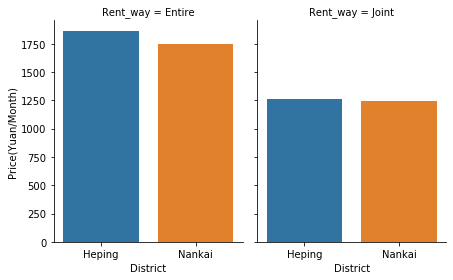

In [18]:
# plt.rcParams['font.sans-serif']=['SimHei']
# # 用来正常显示负号
# plt.rcParams['axes.unicode_minus']=False
a = dfn.groupby(['District','Rent_way']).mean()#均值
a = a.reset_index()#重置索引
sns.catplot(x="District",y='Price(Yuan/Month)',col='Rent_way',data = a,kind = 'bar',height= 4,aspect=0.8)
plt.show()

可见合租无论在南开区还是和平区，平均价格差不多

In [19]:
a = dfn.groupby(['District','Rent_way']).median()#中位数
a

Price(Yuan/Month)  house_area(㎡)
District Rent_way                                  
Heping   Entire               1749.0           38.0
         Joint                1199.0           15.0
Nankai   Entire               1600.0           40.0
         Joint                1264.0           14.5

In [20]:
dfn['price'] = pd.cut(dfn['Price(Yuan/Month)'],[0,800,1000,1200,1500,2000,3000,4000,5000,10000,50000])
dfn[dfn['Price(Yuan/Month)']>4000] 

,House_no.,Rent_way,Name,Price(Yuan/Month),District,house_area(㎡),house_orient,num_bedroom,num_livingroom,num_bathroom,price
18,TJ2490332192580829184,Entire,博朗园,4500,Nankai,49,South,1,1,1,"(4000, 5000]"
19,TJ2387662710595649536,Entire,博朗园,4200,Nankai,46,South,1,1,1,"(4000, 5000]"
364,TJ2397074072933498880,Entire,天津大都会SMART,4109,Heping,56,South,1,1,1,"(4000, 5000]"
366,TJ2338864828468436992,Entire,华润紫阳里,4199,Heping,70,South,2,1,1,"(4000, 5000]"
368,TJ2397074072229396480,Entire,天津大都会SMART,4609,Heping,56,South,1,1,1,"(4000, 5000]"
374,TJ2397074071331274752,Entire,天津大都会SMART,4109,Heping,53,South,1,1,1,"(4000, 5000]"


<font color=b size=3 face=微软雅黑>**极值**</font>

In [21]:
dfn[dfn['District']=='Heping'][['House_no.','Rent_way','house_area(㎡)']].max()  #和平区的最大出租的房屋面积


House_no.        TJ2599326685610647552
Rent_way                         Joint
house_area(㎡)                       72
dtype: object

In [22]:
dfn[dfn['District']=='Nankai'][['House_no.','Rent_way','house_area(㎡)']].max()  #南开区的最大出租的房屋面积


House_no.        TJ2603461092047339520
Rent_way                         Joint
house_area(㎡)                       91
dtype: object

In [23]:
a = dfn.groupby(['District','Rent_way']).skew()#偏态系数
a.reset_index()

,District,Rent_way,Price(Yuan/Month),house_area(㎡)
0,Heping,Entire,1.375332,0.148001
1,Heping,Joint,1.614749,0.606904
2,Nankai,Entire,1.825112,0.839428
3,Nankai,Joint,-0.198259,0.891839


In [24]:
b = dfn.groupby(['District']).skew()#偏态系数
b

,Price(Yuan/Month),house_area(㎡)
District,,
Heping,1.283756,0.220230
Nankai,2.276778,0.970132


<font color=b size=3 face=微软雅黑>**价格分布**</font>

In [25]:
dfn['District'].value_counts()#南开区和和平区的样本数量不一样

Heping    330
Nankai    123
Name: District, dtype: int64

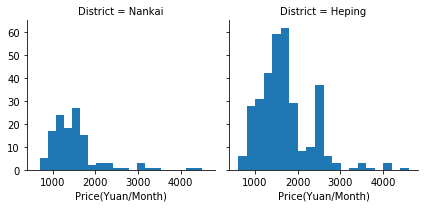

In [26]:
#区域价格频数分布
g = sns.FacetGrid(dfn,col='District')
g.map(plt.hist,'Price(Yuan/Month)',bins=20)


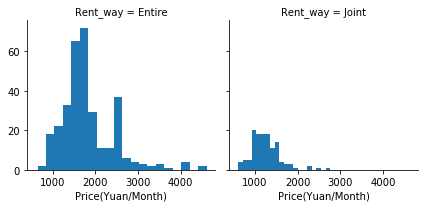

In [27]:
#租房方式价格频数分布
h = sns.FacetGrid(dfn,col='Rent_way')
h.map(plt.hist,'Price(Yuan/Month)',bins=20)


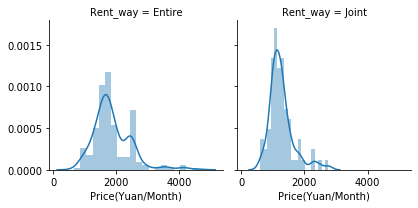

In [28]:
#和平区价格频率分布
dfhp = dfn[dfn['District'] == 'Heping'][['District','Rent_way','Price(Yuan/Month)']]
i = sns.FacetGrid(dfhp,col='Rent_way')
i.map(sns.distplot,'Price(Yuan/Month)',bins=20)

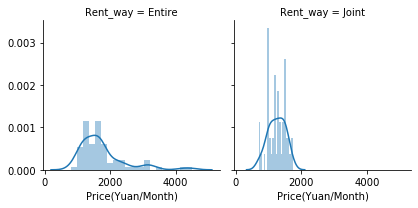

In [29]:
#南开区价格频率分布
dfhp = dfn[dfn['District'] == 'Nankai'][['District','Rent_way','Price(Yuan/Month)']]
j = sns.FacetGrid(dfhp,col='Rent_way')
j.map(sns.distplot,'Price(Yuan/Month)',bins=20)

<font color=b size=3 face=微软雅黑>**房屋朝向占比**</font>

In [30]:
orient_count = dfn['house_orient'].value_counts() #查看出租房屋及卧室朝向,可见朝向为南的房子出租数量较多
orient_count

South        223
East          48
North         39
N-S           38
Southeast     28
Southwest     19
others        16
West          16
E-W           11
Northwest     10
Northeast      5
Name: house_orient, dtype: int64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


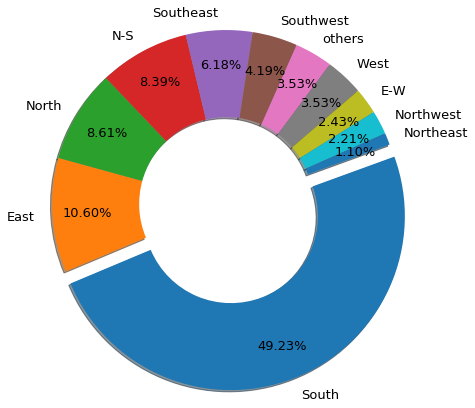

In [31]:
#不同朝向的房子占总体样本的比例
%matplotlib inline
explode = (0.15,0,0,0,0,0,0,0,0,0,0)
plt.pie(orient_count, labels = orient_count.index,radius=2,autopct='%3.2f%%',textprops={'fontsize':13,'color':'k'}
        ,explode = explode,shadow=True,startangle=20,pctdistance = 0.8,
       counterclock = False, wedgeprops = {'width' : 1}
       )

#pctdistance
plt.show()

#         counterclock = False, wedgeprops = {'width' : 0.4})

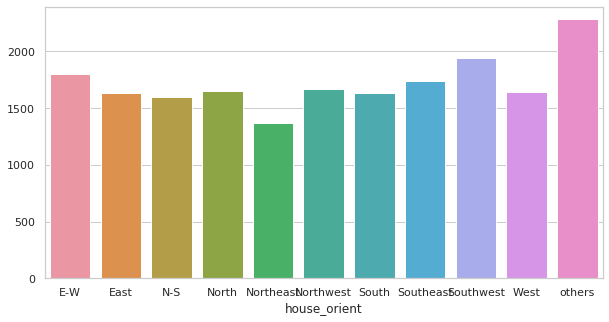

In [32]:
#不同朝向的房子的均价
col = ['house_orient','Price(Yuan/Month)']
df1 = dfn[col]
#df1 = pd.DataFrame(
df1= df1.groupby('house_orient')['Price(Yuan/Month)'].mean()
#sns.heatmap(df1)
plt.figure(figsize = (10,5))
sns.set(style="whitegrid")
sns.barplot(x=df1.index,y=df1.values)